# Component 5: Train Baseline CNN

50 epochs, ModelCheckpoint + ReduceLROnPlateau, **NO EarlyStopping**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

OUTPUT_DIR = '../outputs'
os.makedirs(f'{OUTPUT_DIR}/models', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/training_history', exist_ok=True)
print('✓ Setup complete')

✓ Setup complete


## Load Data

In [2]:
train_df = pd.read_csv('../outputs/train_manifest.csv')
val_df = pd.read_csv('../outputs/val_manifest.csv')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = len(train_df['class_label'].unique())

print(f'Train: {{len(train_df)}} images')
print(f'Val:   {{len(val_df)}} images')
print(f'Classes: {{NUM_CLASSES}}')

Train: {len(train_df)} images
Val:   {len(val_df)} images
Classes: {NUM_CLASSES}


## Preprocessing & Augmentation

In [3]:
def preprocess(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

def build_dataset(df, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['class_label'].values))
    ds = ds.map(preprocess, tf.data.AUTOTUNE).cache()
    if augment:
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y))
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = build_dataset(train_df, augment=True, shuffle=True)
val_ds = build_dataset(val_df, augment=False, shuffle=False)
print('✓ Datasets created')

2026-01-31 11:25:01.312650: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-01-31 11:25:01.312677: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-31 11:25:01.312684: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-31 11:25:01.312700: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-31 11:25:01.312709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✓ Datasets created


## Build Baseline CNN Model

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

/Users/amitabhthakur/Workspace/Projects/ML/AD/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,724 (1.61 MB)

 Trainable params: 422,276 (1.61 MB)

 Non-trainable params: 448 (1.75 KB)

## Compile & Setup

In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['class_label']),
    y=train_df['class_label']
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print('Class weights:', class_weight_dict)

Class weights: {0: 1.3105867346938775, 1: 3.277511961722488, 2: 5.838068181818182, 3: 0.36224219989423584}


## Callbacks (NO EarlyStopping!)

In [6]:
# ModelCheckpoint - saves best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{OUTPUT_DIR}/models/baseline_cnn_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# ReduceLROnPlateau - reduces learning rate when stuck
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, reduce_lr]
print('✓ Callbacks configured (NO EarlyStopping)')

✓ Callbacks configured (NO EarlyStopping)


## Train Model

In [7]:
print(f'\nStarting training for {EPOCHS} epochs...')
print('='*60)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print('\n' + '='*60)
print('✅ TRAINING COMPLETE')
print('='*60)


Starting training for 50 epochs...
Epoch 1/50


2026-01-31 11:25:02.250543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.3742 - loss: 1.3157
Epoch 1: val_accuracy improved from None to 0.68995, saving model to ../outputs/models/baseline_cnn_best.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 96s 352ms/step - accuracy: 0.4308 - loss: 1.2514 - val_accuracy: 0.6899 - val_loss: 1.6776 - learning_rate: 1.0000e-04
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.5289 - loss: 1.1213
Epoch 2: val_accuracy improved from 0.68995 to 0.70415, saving model to ../outputs/models/baseline_cnn_best.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 126s 476ms/step - accuracy: 0.5341 - loss: 1.1627 - val_accuracy: 0.7041 - val_loss: 1.3103 - learning_rate: 1.0000e-04
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5562 - loss: 1.1489
Epoch 3: val_accuracy did not improve from 0.70415
257/257 ━━━━━━━━━━━━━━━━━━━━ 105s 391ms/step - accuracy: 0.5700 - loss: 1.2001 - val_accuracy: 0.6479 - val_loss: 0.7456 - learning_rate: 1.0000e-04
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.5844 - loss: 1.1213
Epoch 4: val_accuracy improved from 0.70415 to 0.73311, saving model to ../outputs/models/baseline_cnn_best.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 105s 394ms/step - accuracy: 0.5939 - loss: 1.1335 - val_accuracy: 0.7331 - val_loss: 0.5816 - learning_rate: 1.0000e-04
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.6052 - loss: 1.1049
Epoch 5: val_accuracy did not improve from 0.73311
257/257 ━━━━━━━━━━━━━━━━━━━━ 103s 387ms/step - accuracy: 0.5998 - loss: 1.1512 - val_accuracy: 0.7172 - val_loss: 0.6644 - learning_rate: 1.0000e-04
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.6017 - loss: 1.2402
Epoch 6: val_accuracy improved from 0.73311 to 0.73822, saving model to ../outputs/models/baseline_cnn_best.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 108s 404ms/step - accuracy: 0.6108 - loss: 1.2177 - val_accuracy: 0.7382 - val_loss: 0.6068 - learning_rate: 1.0000e-04
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.6051 - loss: 1.2008
Epoch 7: val_accuracy did not improve from 0.73822

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
257/257 ━━━━━━━━━━━━━━━━━━━━ 115s 430ms/step - accuracy: 0.6043 - loss: 1.2787 - val_accuracy: 0.7178 - val_loss: 0.9516 - learning_rate: 1.0000e-04
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6195 - loss: 1.2317
Epoch 8: val_accuracy did not improve from 0.73822
257/257 ━━━━━━━━━━━━━━━━━━━━ 112s 418ms/step - accuracy: 0.6223 - loss: 1.2784 - val_accuracy: 0.7246 - val_loss: 0.6311 - learning_rate: 5.0000e-05
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.6234 - loss: 1.2254
Epoch 9: val_accuracy did not improve from 0.73822
257/257 ━━━━━━━━━━━━━━━━━━━━ 115s 432ms/step - accuracy: 0.

257/257 ━━━━━━━━━━━━━━━━━━━━ 110s 412ms/step - accuracy: 0.6212 - loss: 1.3194 - val_accuracy: 0.7416 - val_loss: 0.6242 - learning_rate: 2.5000e-05
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6174 - loss: 1.2803
Epoch 12: val_accuracy did not improve from 0.74162
257/257 ━━━━━━━━━━━━━━━━━━━━ 111s 414ms/step - accuracy: 0.6195 - loss: 1.3249 - val_accuracy: 0.7337 - val_loss: 0.7060 - learning_rate: 2.5000e-05
Epoch 13/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6321 - loss: 1.2827
Epoch 13: val_accuracy did not improve from 0.74162

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
257/257 ━━━━━━━━━━━━━━━━━━━━ 110s 413ms/step - accuracy: 0.6305 - loss: 1.3529 - val_accuracy: 0.7354 - val_loss: 0.6919 - learning_rate: 2.5000e-05
Epoch 14/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.6145 - loss: 1.3948
Epoch 14: val_accuracy did not improve from 0.74162
257/257 ━━━━━━━━━━━━━━━━━━━━ 109s 408ms/step - accur

## Save History & Plots

✓ History saved to ../outputs/training_history/baseline_cnn_history.json
✓ History saved to ../outputs/training_history/baseline_cnn_history.csv


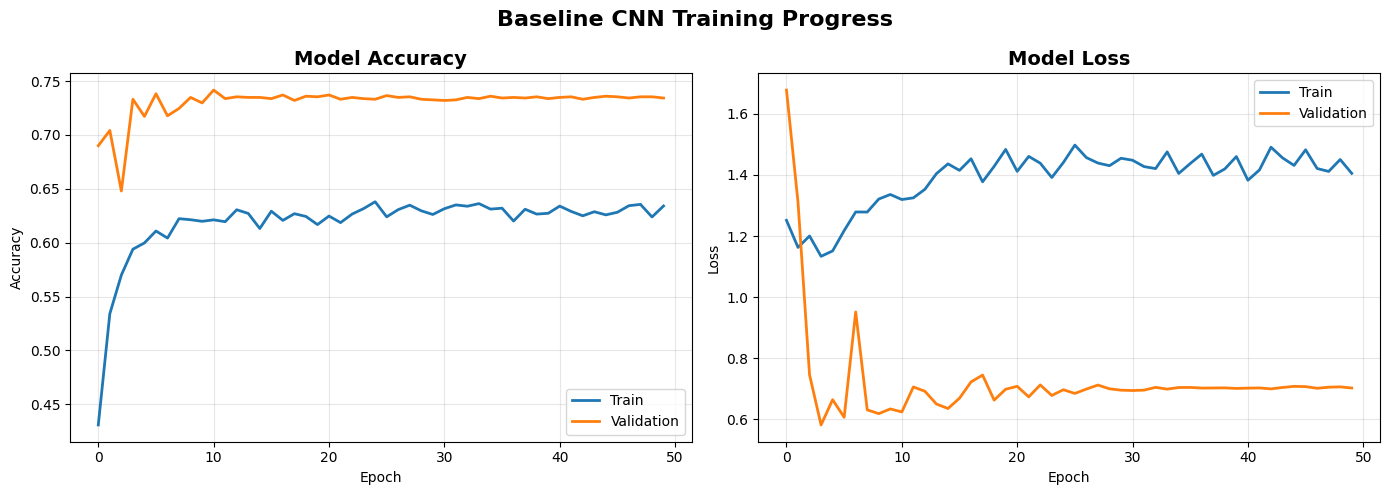

✓ Training curves saved to ../outputs/training_history/baseline_cnn_curves.png

Best model saved to: ../outputs/models/baseline_cnn_best.h5
Best val_accuracy: 0.7416


In [8]:
# Save history as JSON and CSV
history_dict = history.history
history_path = f'{OUTPUT_DIR}/training_history/baseline_cnn_history.json'
csv_path = f'{OUTPUT_DIR}/training_history/baseline_cnn_history.csv'

with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=2)

import pandas as pd
pd.DataFrame(history_dict).to_csv(csv_path, index=False)

print(f'✓ History saved to {history_path}')
print(f'✓ History saved to {csv_path}')

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history_dict['accuracy'], label='Train', linewidth=2)
ax1.plot(history_dict['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(alpha=0.3)

# Loss
ax2.plot(history_dict['loss'], label='Train', linewidth=2)
ax2.plot(history_dict['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle(f'Baseline CNN Training Progress', fontsize=16, fontweight='bold')
plt.tight_layout()

plot_path = f'{OUTPUT_DIR}/training_history/baseline_cnn_curves.png'
plt.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.show()

print(f'✓ Training curves saved to {plot_path}')
print(f'\nBest model saved to: {OUTPUT_DIR}/models/baseline_cnn_best.h5')
print(f'Best val_accuracy: {max(history_dict["val_accuracy"]):.4f}')